# Modelos SARIMA

In [82]:
import numpy as np
import models
import metrics
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.stattools import kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pmdarima.arima import auto_arima
import warnings
warnings.filterwarnings("ignore")

### Carregando os dados

In [83]:
us_change = pd.read_csv('us_change.csv')
us_change

,Quarter,Consumption,Income,Production,Savings,Unemployment
0,1970 Q1,0.618566,1.044801,-2.452486,5.299014,0.9
1,1970 Q2,0.451984,1.225647,-0.551459,7.789894,0.5
2,1970 Q3,0.872872,1.585154,-0.358652,7.403984,0.5
3,1970 Q4,-0.271848,-0.239545,-2.185691,1.169898,0.7
4,1971 Q1,1.901345,1.975925,1.909764,3.535667,-0.1
...,...,...,...,...,...,...
193,2018 Q2,0.983112,0.661825,1.117424,-2.723974,0.0
194,2018 Q3,0.853181,0.806271,1.256722,-0.085686,-0.3
195,2018 Q4,0.356512,0.695142,0.948148,5.031337,0.2
196,2019 Q1,0.282885,1.100753,-0.488206,9.760287,-0.1


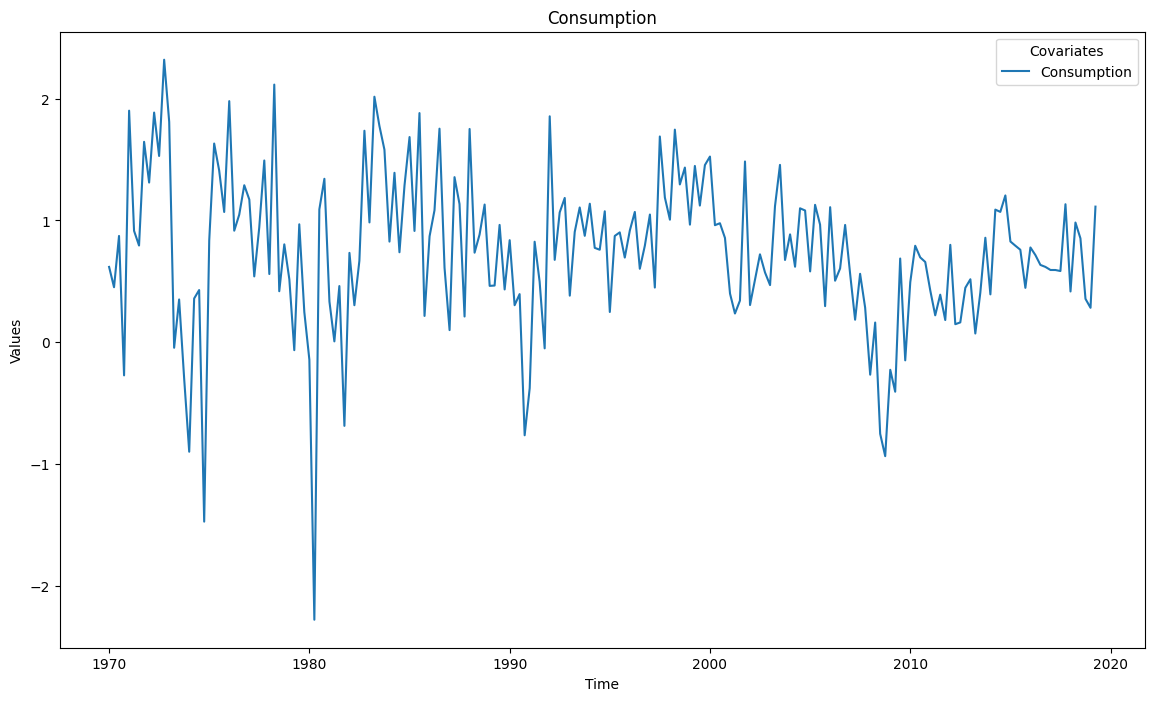

In [84]:
# Convert the 'Quarter' column to datetime format
def parse_quarter(quarter_str):
    year, quarter = quarter_str.split(' ')
    month = (int(quarter[1]) - 1) * 3 + 1
    return pd.Timestamp(f'{year}-{month:02d}-01')

us_change['Quarter'] = us_change['Quarter'].apply(parse_quarter)

# Set the 'Quarter' column as the index
us_change.set_index('Quarter', inplace=True)

# Plot all covariates as time series
plt.figure(figsize=(14, 8))
sns.lineplot(data=us_change['Consumption'], label='Consumption')
plt.title('Consumption')
plt.xlabel('Time')
plt.ylabel('Values')
plt.legend(title='Covariates')
plt.show()

In [85]:
us_change['Consumption'][:-12]

Quarter
1970-01-01    0.618566
1970-04-01    0.451984
1970-07-01    0.872872
1970-10-01   -0.271848
1971-01-01    1.901345
                ...   
2015-04-01    0.792813
2015-07-01    0.759427
2015-10-01    0.446824
2016-01-01    0.778254
2016-04-01    0.715591
Name: Consumption, Length: 186, dtype: float64

### Decomposição entre tendência e sazonalidade

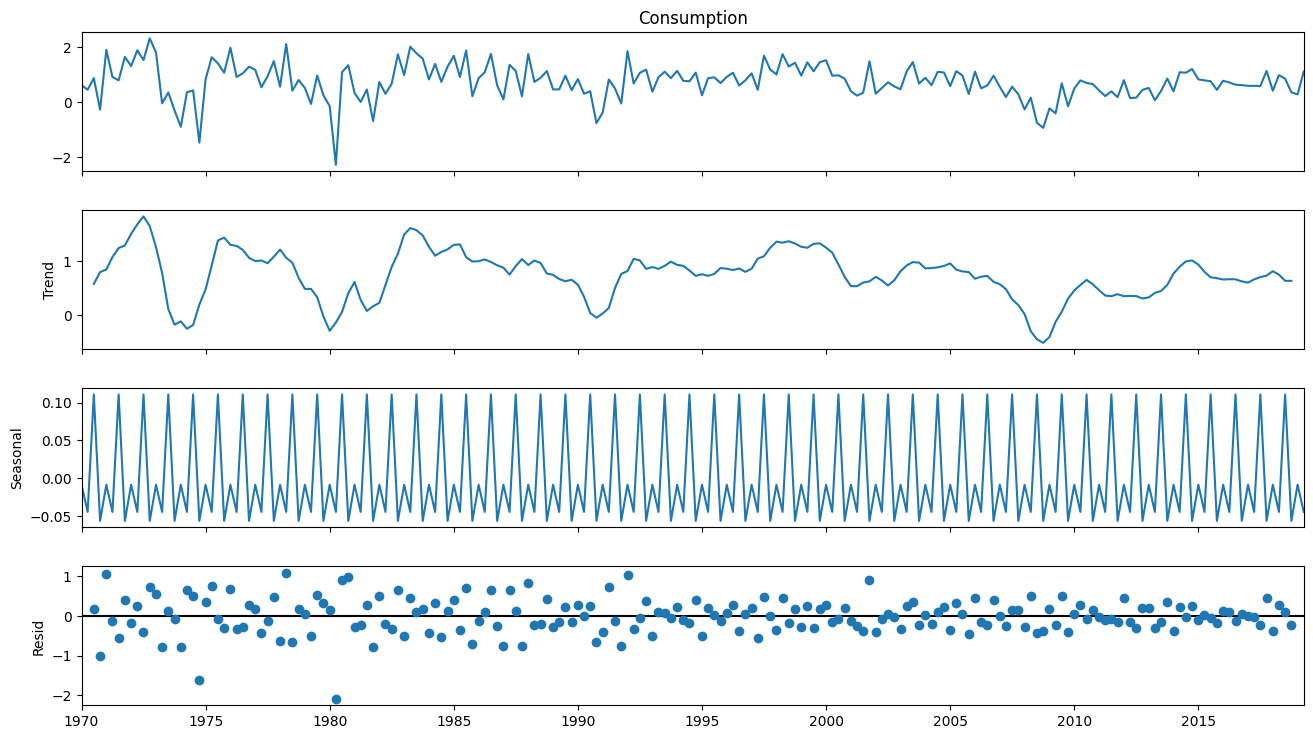

In [86]:
# Decompose the time series
decomposition = seasonal_decompose(us_change['Consumption'], model='additive')
fig = decomposition.plot()
fig.set_size_inches(14, 8)
plt.show()

### Teste de estacionariedade

In [87]:
# KPSS test
kpss = kpss(us_change['Consumption'][:-12], regression='c')

print(f'KPSS Statistic: {kpss[0]}')
print(f'p-value: {kpss[1]}')
print(f'Num of lags: {kpss[2]}')
print('Critical values:')
for key, value in kpss[3].items():
    print(f'   {key}: {value}')
    
if kpss[1] < 0.05:
    print('The series is not stationary.')
else:
    print('The series is stationary.')

KPSS Statistic: 0.21946193516295484
p-value: 0.1
Num of lags: 7
Critical values:
   10%: 0.347
   5%: 0.463
   2.5%: 0.574
   1%: 0.739
The series is stationary.


### Identificação de hiperparâmetros

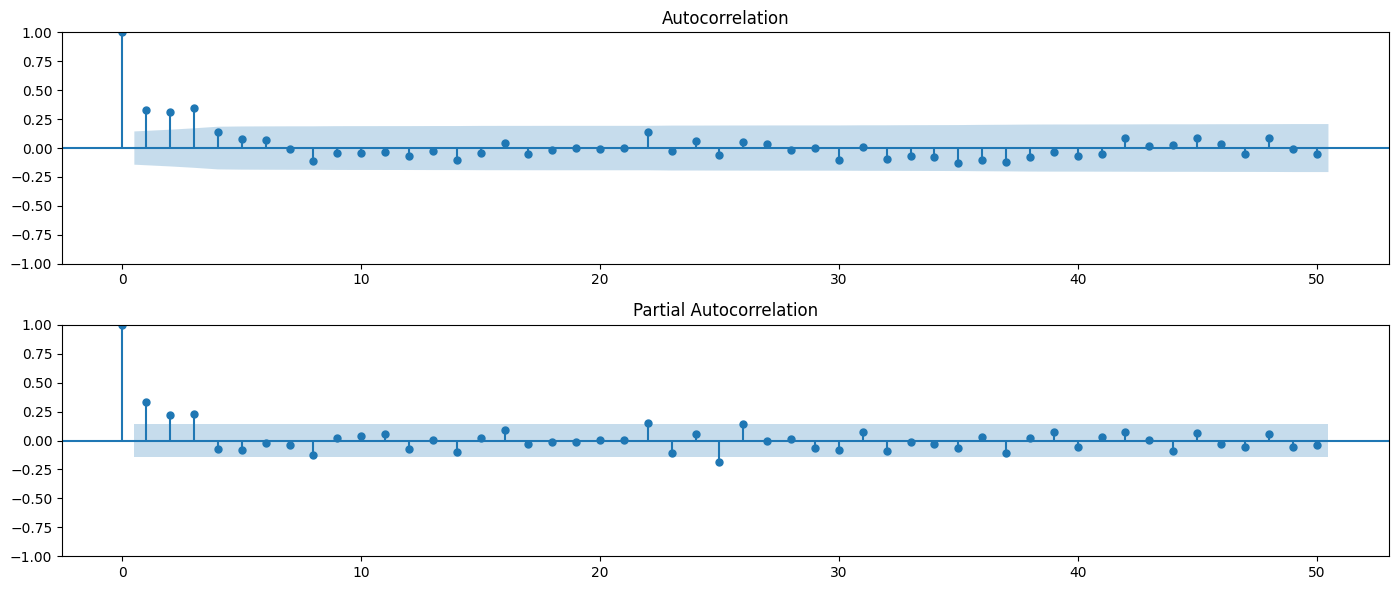

In [88]:
series = us_change['Consumption'][:-12]
plt.figure(figsize=(14, 6))
plt.subplot(211)
plot_acf(series, lags=50, ax=plt.gca())
plt.subplot(212)
plot_pacf(series, lags=50, ax=plt.gca())
plt.tight_layout()
plt.show()


### Ajuste de modelos e seleção automática

In [89]:
# Fit auto_arima function to dataset
stepwise_fit = auto_arima(us_change['Consumption'][:-12], start_p=1, start_q=1,
                          max_p=3, max_q=3, m=4,
                          seasonal=True,
                          d=None, D=1, trace=True,
                          error_action='ignore',
                          suppress_warnings=True,
                          stepwise=True)

# Display summary
stepwise_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(1,1,1)[4] intercept   : AIC=inf, Time=0.36 sec
 ARIMA(0,0,0)(0,1,0)[4] intercept   : AIC=466.213, Time=0.04 sec
 ARIMA(1,0,0)(1,1,0)[4] intercept   : AIC=435.834, Time=0.08 sec
 ARIMA(0,0,1)(0,1,1)[4] intercept   : AIC=inf, Time=0.22 sec
 ARIMA(0,0,0)(0,1,0)[4]             : AIC=464.221, Time=0.03 sec
 ARIMA(1,0,0)(0,1,0)[4] intercept   : AIC=463.869, Time=0.04 sec
 ARIMA(1,0,0)(2,1,0)[4] intercept   : AIC=416.319, Time=0.13 sec
 ARIMA(1,0,0)(2,1,1)[4] intercept   : AIC=inf, Time=0.70 sec
 ARIMA(1,0,0)(1,1,1)[4] intercept   : AIC=inf, Time=0.40 sec
 ARIMA(0,0,0)(2,1,0)[4] intercept   : AIC=425.945, Time=0.12 sec
 ARIMA(2,0,0)(2,1,0)[4] intercept   : AIC=409.875, Time=0.15 sec
 ARIMA(2,0,0)(1,1,0)[4] intercept   : AIC=432.977, Time=0.13 sec
 ARIMA(2,0,0)(2,1,1)[4] intercept   : AIC=inf, Time=0.57 sec
 ARIMA(2,0,0)(1,1,1)[4] intercept   : AIC=inf, Time=0.62 sec
 ARIMA(3,0,0)(2,1,0)[4] intercept   : AIC=403.379, Time=0.17 sec
 ARIMA

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  186
Model:             SARIMAX(3, 0, 1)x(2, 1, [], 4)   Log Likelihood                -186.729
Date:                            Tue, 26 Nov 2024   AIC                            387.459
Time:                                    12:19:14   BIC                            409.887
Sample:                                01-01-1970   HQIC                           396.551
                                     - 04-01-2016                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6784      0.067    -10.072      0.000      -0.810      -0.546
ar.L2          0.3317      0.082      4.051      0.000       0.171       0.492
ar.L3          0.3261      0.066      4.940      0.000       0.197       0.455
ma.L1          0.9841      0.031     32.257      0.000       0.924       1.044
ar.S.L4       -0.4814      0.067     -7.187      0.000      -0.613      -0.350
ar.S.L8       -0.3418      0.066     -5.199      0.000      -0.471      -0.213
sigma2         0.4436      0.043     10.401      0.000       0.360       0.527
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):                 7.68
Prob(Q):                              0.87   Prob(JB):                         0.02
Heteroskedasticity (H):               0.24   Skew:                            -0.33
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.76
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

#### 1. ARIMA

                               SARIMAX Results                                
Dep. Variable:            Consumption   No. Observations:                  186
Model:                 ARIMA(3, 0, 1)   Log Likelihood                -163.988
Date:                Tue, 26 Nov 2024   AIC                            339.977
Time:                        12:19:15   BIC                            359.331
Sample:                    01-01-1970   HQIC                           347.820
                         - 04-01-2016                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.7443      0.110      6.753      0.000       0.528       0.960
ar.L1          0.0325      0.267      0.122      0.903      -0.491       0.556
ar.L2          0.2064      0.087      2.360      0.0

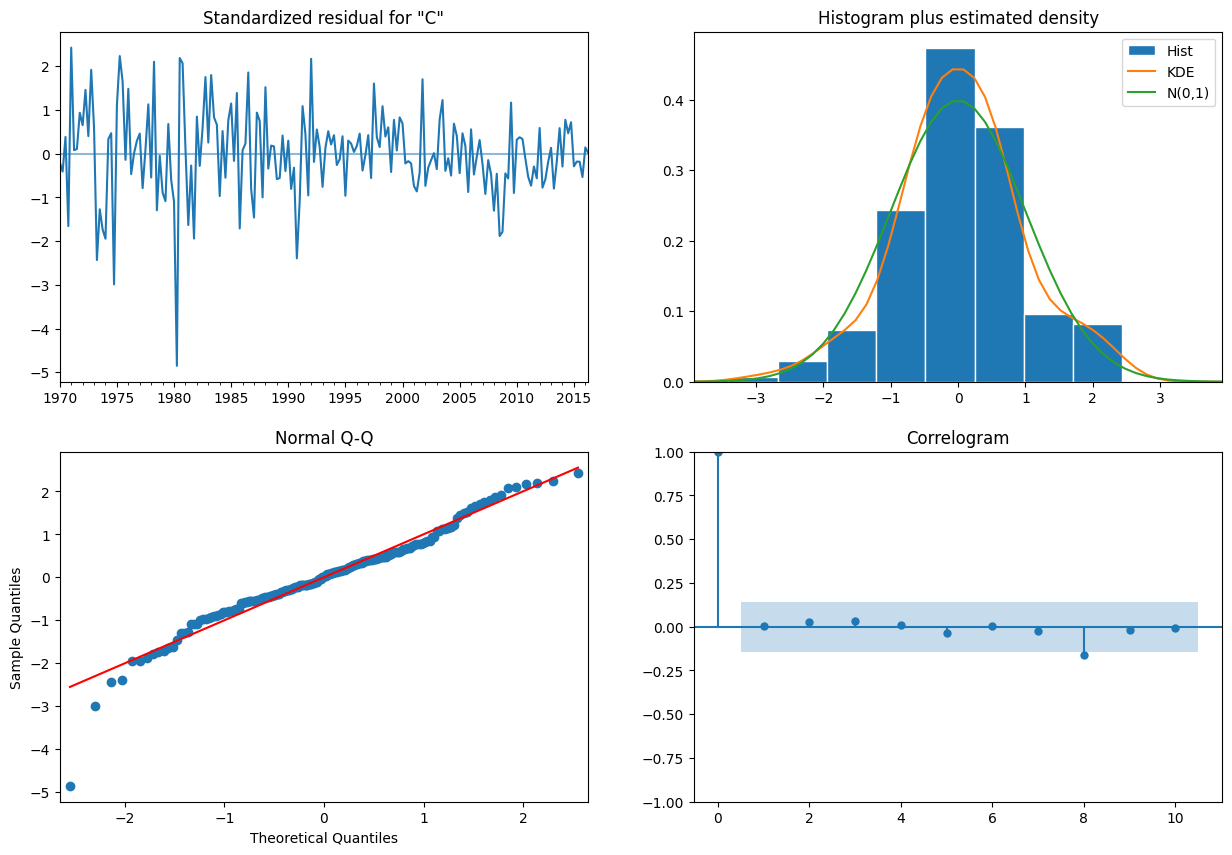

In [90]:
consumption_train = us_change['Consumption'].iloc[:-12]
consumption_test = us_change['Consumption'].iloc[-12:]

arima = models.ARIMA(3, 0, 1)
results_arima = arima.fit(consumption_train)

print(results_arima.summary())
results_arima.plot_diagnostics(figsize=(15, 10))
plt.show()

#### 2. SARIMA

                                     SARIMAX Results                                      
Dep. Variable:                        Consumption   No. Observations:                  186
Model:             SARIMAX(3, 0, 1)x(2, 1, [], 4)   Log Likelihood                -186.729
Date:                            Tue, 26 Nov 2024   AIC                            387.459
Time:                                    12:19:16   BIC                            409.887
Sample:                                01-01-1970   HQIC                           396.551
                                     - 04-01-2016                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6784      0.067    -10.072      0.000      -0.810      -0.546
ar.L2          0.3317      0.082   

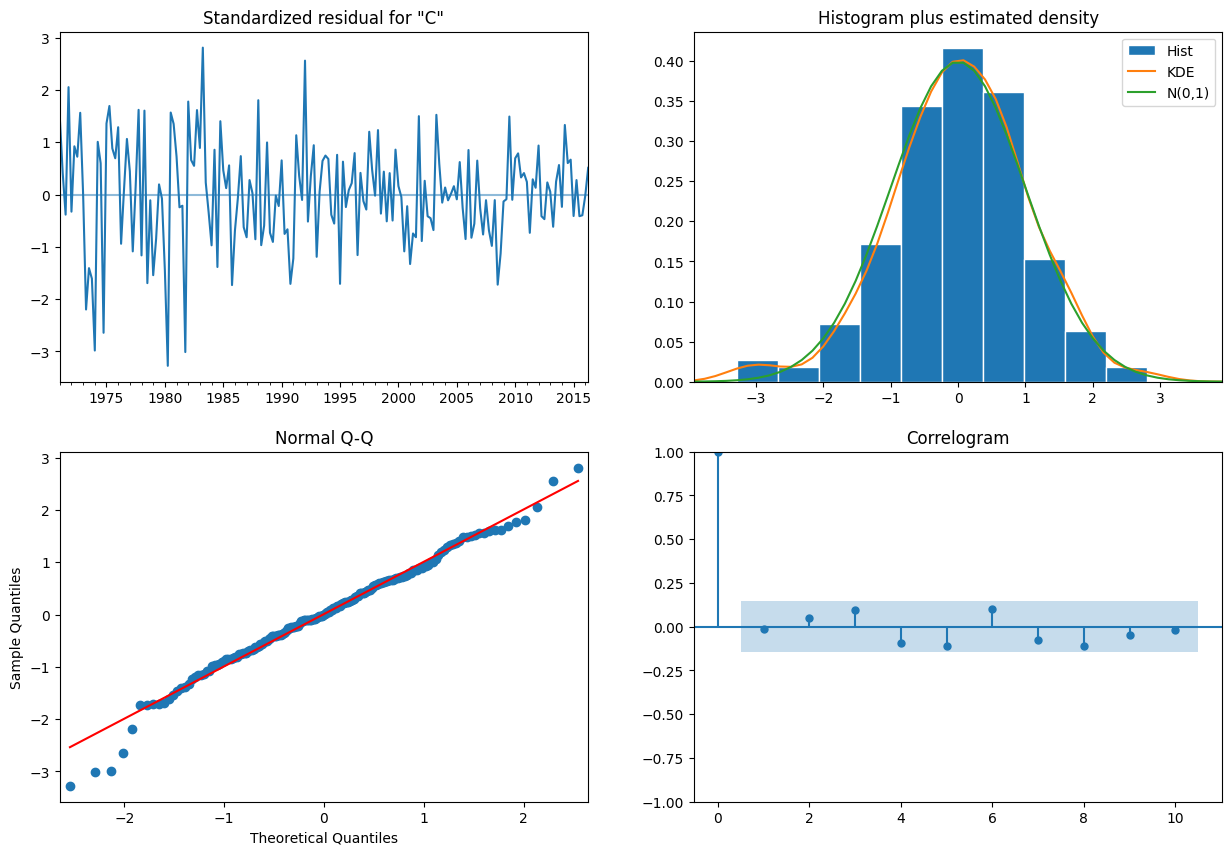

In [91]:
sarima = models.SARIMA(3, 0, 1, 2, 1, 0, 4)
results_sarima = sarima.fit(consumption_train)

print(results_sarima.summary())
results_sarima.plot_diagnostics(figsize=(15, 10))
plt.show()

### Previsão e ajuste de modelos

In [92]:
# Create a DataFrame with the predictions
predictions = pd.DataFrame({
    'ARIMA': arima.predict(12),
    'SARIMA': sarima.predict(12)
})

fitted_values = pd.DataFrame({
    'ARIMA': arima.fitted_values,
    'SARIMA': sarima.fitted_values
})

predictions

,ARIMA,SARIMA
2016-07-01,0.674209,0.822737
2016-10-01,0.745058,0.678521
2017-01-01,0.722304,0.751844
2017-04-01,0.725285,0.828255
2017-07-01,0.739354,0.943807
2017-10-01,0.734430,0.819099
2018-01-01,0.737960,0.792818
2018-04-01,0.740765,0.804990
2018-07-01,0.740287,0.862248
2018-10-01,0.741781,0.678599


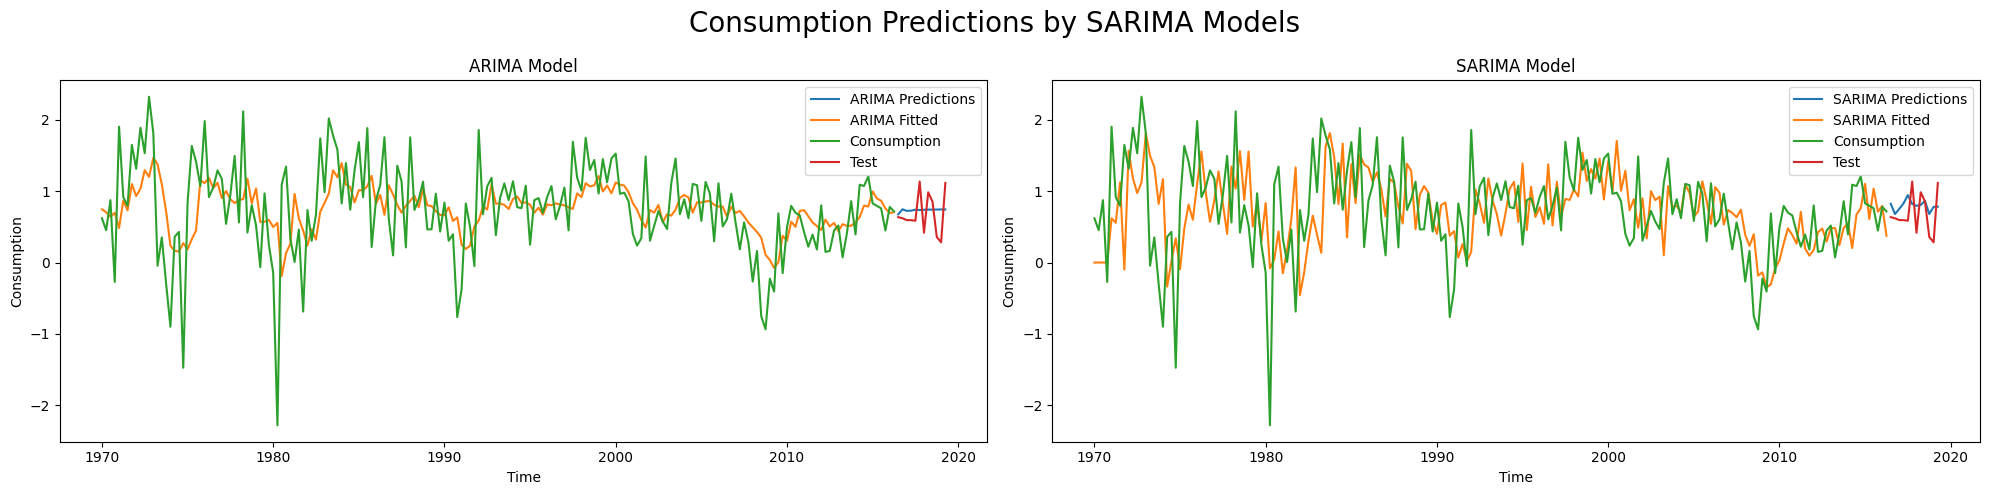

In [93]:
fig, axes = plt.subplots(1, 2, figsize=(20, 5), sharex=True)
fig.suptitle('Consumption Predictions by SARIMA Models', fontsize=20)
for ax, model in zip(axes.flatten(), predictions.columns):
    # Create a new series for the predictions
    prediction_series = pd.Series(predictions[model].values, 
                                  index=pd.date_range(start=consumption_train.index[-1], periods=12, freq='QE'))
    
    
    # Plot the prediction series
    sns.lineplot(data=prediction_series, ax=ax, label=f'{model} Predictions')
    
    # Plot the fitted values
    sns.lineplot(data=fitted_values[model], ax=ax, label=f'{model} Fitted')
    
    #plot consumption data
    sns.lineplot(data=consumption_train, ax=ax, label='Consumption')
    sns.lineplot(data=consumption_test, ax=ax, label='Test')
    
    ax.set_title(f'{model} Model')
    ax.set_xlabel('Time')
    ax.set_ylabel('Consumption')

plt.tight_layout()
plt.show()

### Avaliação de modelos

#### 1. Resíduos

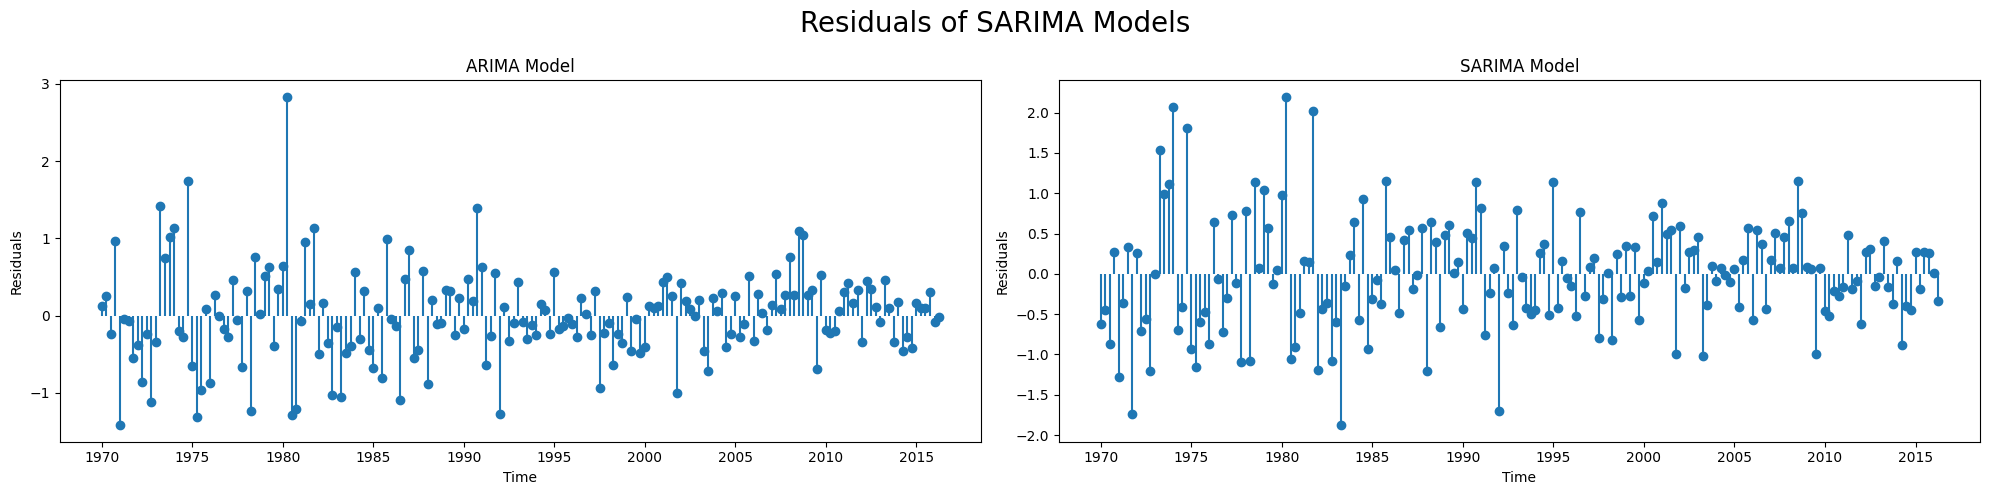

In [94]:
residuals = fitted_values.subtract(consumption_train.values, axis=0)

fig, axes = plt.subplots(1, 2, figsize=(20, 5), sharex=True)
fig.suptitle('Residuals of SARIMA Models', fontsize=20)

for ax, model in zip(axes.flatten(), residuals.columns):
    residuals_series = pd.Series(residuals[model].values, index=consumption_train.index)
    
    ax.stem(residuals_series.index, residuals_series.values, basefmt=" ")
    
    ax.set_title(f'{model} Model')
    ax.set_xlabel('Time')
    ax.set_ylabel('Residuals')
    
plt.tight_layout()
plt.show()

#### 2. Teste de Ljung-Box

In [95]:
ljung_box_results = {}
for model in residuals.columns:
    ljung_box_results[model] = acorr_ljungbox(residuals[model], lags=[10], return_df=True)

# Display the Ljung-Box test results
for model, result in ljung_box_results.items():
    print(f"Ljung-Box Test for {model} Model:")
    print(result)

Ljung-Box Test for ARIMA Model:
     lb_stat  lb_pvalue
10  6.023154   0.813314
Ljung-Box Test for SARIMA Model:
      lb_stat  lb_pvalue
10  11.147984   0.346106


#### 3. Métricas

In [96]:
# Calculate metrics for each model
results = {}
for model in predictions.columns:
    y_pred = predictions[model].values
    y_true = consumption_test.values
    results[model] = {
        'MAE': metrics.mae(y_true, y_pred),
        'MSE': metrics.mse(y_true, y_pred),
        'RMSE': metrics.rmse(y_true, y_pred),
        'MAPE': metrics.mape(y_true, y_pred),
        'SMAPE': metrics.smape(y_true, y_pred),
        'MASE': metrics.mase(y_true, y_pred, consumption_train.values),
        'R2': metrics.r2(y_true, y_pred),
        'AIC': metrics.aic(y_true, y_pred, 2),
        'BIC': metrics.bic(y_true, y_pred, 2)   
    }

# Convert results to DataFrame
results_df = pd.DataFrame(results).T
results_df

,MAE,MSE,RMSE,MAPE,SMAPE,MASE,R2,AIC,BIC
ARIMA,0.239347,0.075518,0.274805,45.915257,35.657758,0.421181,-0.033761,-27.000683,-26.030870
SARIMA,0.252290,0.081643,0.285733,49.959546,37.051460,0.443955,-0.117618,-26.064734,-25.094921


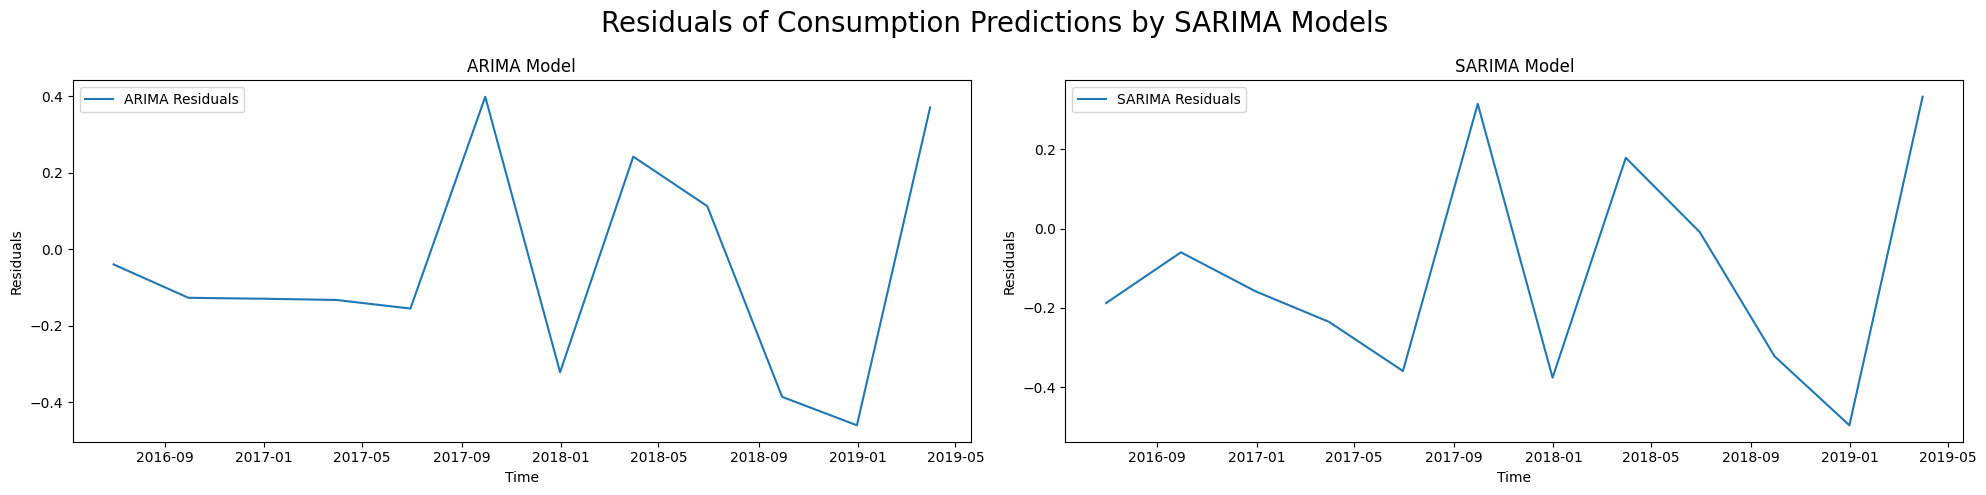

In [97]:
# Calculate the residuals for each model
residuals = {}
for model in predictions.columns:
    y_pred = predictions[model].values
    y_true = consumption_test.values
    residuals[model] = y_true - y_pred

# Plot the residuals
fig, axes = plt.subplots(1, 2, figsize=(20, 5), sharex=True)
fig.suptitle('Residuals of Consumption Predictions by SARIMA Models', fontsize=20)
for ax, model in zip(axes.flatten(), residuals.keys()):
    # Create a new series for the residuals
    residual_series = pd.Series(residuals[model], 
                                index=pd.date_range(start=consumption_train.index[-1], periods=12, freq='QE'))
    
    # Plot the residuals series
    sns.lineplot(data=residual_series, ax=ax, label=f'{model} Residuals')
    
    ax.set_title(f'{model} Model')
    ax.set_xlabel('Time')
    ax.set_ylabel('Residuals')
    
plt.tight_layout()
plt.show()

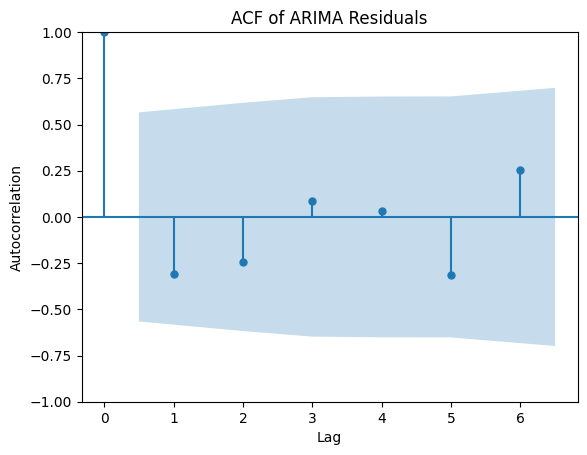

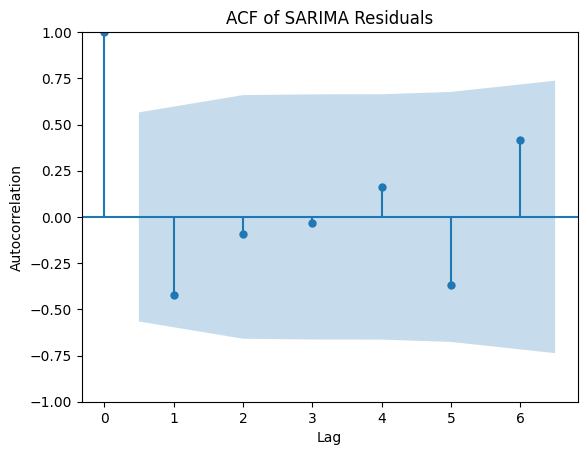

In [98]:
for residual in residuals:
    plot_acf(residuals[residual])
    plt.title(f'ACF of {residual} Residuals')
    plt.xlabel('Lag')
    plt.ylabel('Autocorrelation')
    plt.show()